# Stock Prediction using LSTMs

In this notebook, we try to predict tomorrow's price of an asset (say, AAPL's stock price) from the closing price from the last 60 days, using a recurrent neural network called Long Short Term Memory (LSTM).

![image](_static/StockPrediction_LSTM.png)

In [1]:
import math
import pandas_datareader as pdr
import pandas as pd
import numpy as np
import datetime as dt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
import yfinance as yf

yf.pdr_override()

2023-08-12 11:50:09.634395: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-08-12 11:50:09.636067: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-12 11:50:09.669362: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-12 11:50:09.670009: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-12 11:50:10.289982: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

In [2]:
df = pdr.data.get_data_yahoo('AAPL', start='2012-01-01', end='2019-12-17')
df

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2012-01-03,14.621429,14.732143,14.607143,14.686786,12.466095,302220800
2012-01-04,14.642857,14.810000,14.617143,14.765714,12.533088,260022000
2012-01-05,14.819643,14.948214,14.738214,14.929643,12.672230,271269600
2012-01-06,14.991786,15.098214,14.972143,15.085714,12.804704,318292800
2012-01-09,15.196429,15.276786,15.048214,15.061786,12.784390,394024400
...,...,...,...,...,...,...
2019-12-10,67.150002,67.517502,66.464996,67.120003,65.476608,90420400
2019-12-11,67.202499,67.775002,67.125000,67.692497,66.035088,78756800
2019-12-12,66.945000,68.139999,66.830002,67.864998,66.203377,137310400


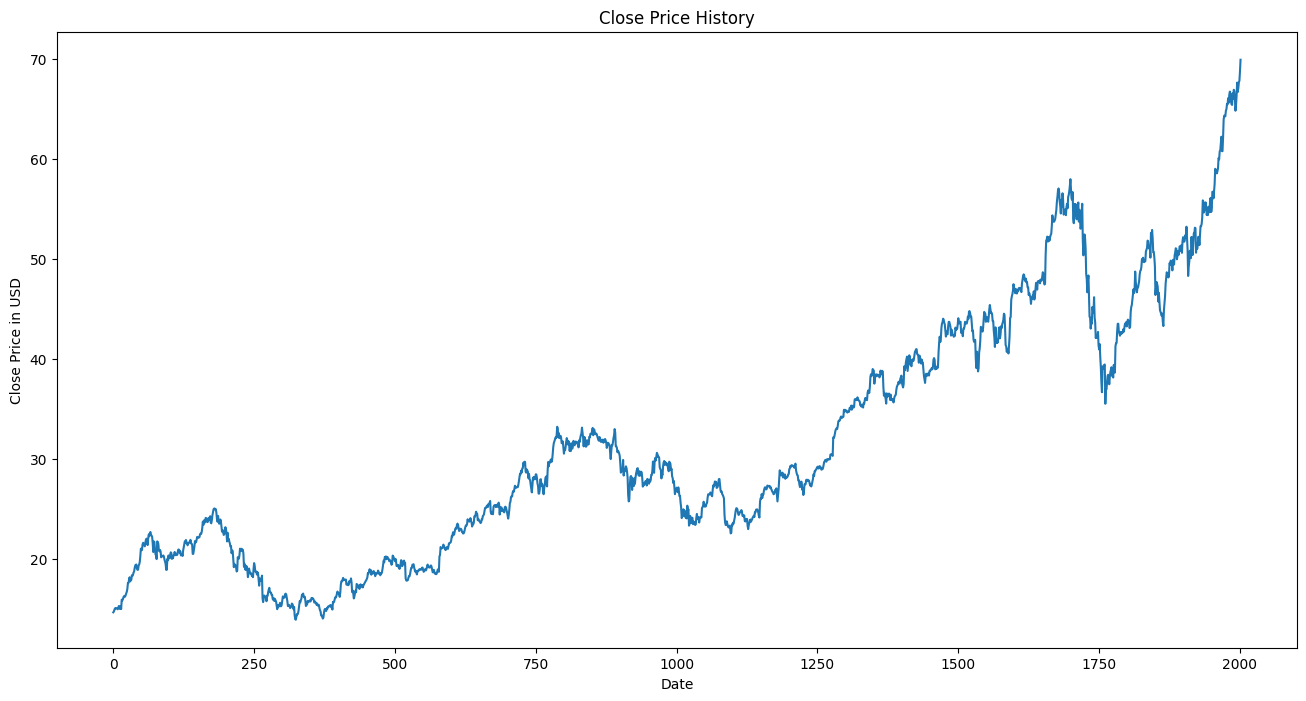

In [3]:
close = df.filter(['Close']).values
plt.figure(figsize=(16,8))
plt.plot(close)
plt.xlabel('Date')
plt.ylabel('Close Price in USD')
plt.title('Close Price History')
plt.show()

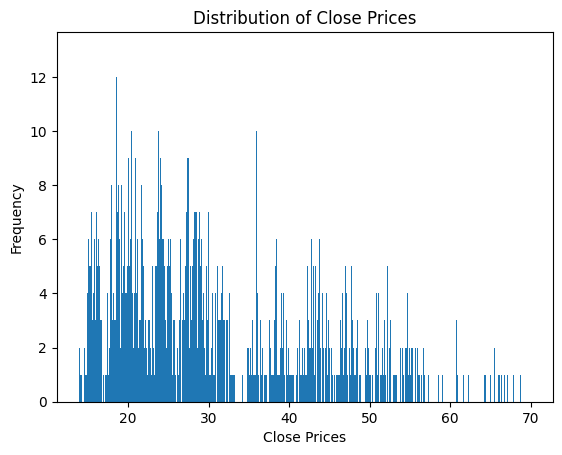

In [4]:
plt.figure()
plt.hist(close, bins=1000)
plt.xlabel('Close Prices')
plt.ylabel('Frequency')
plt.title('Distribution of Close Prices')
plt.show()

In [5]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled_close_prices = scaler.fit_transform(close)

In [6]:
x, y = [], []
for i in range(60, len(scaled_close_prices)):
    x.append(scaled_close_prices[i-60:i, :])
    y.append(scaled_close_prices[i, :])
x = np.array(x)
y = np.array(y)

train_len = int(0.8*(len(x)))
test_len = len(x) - train_len

x_train = x[:train_len]
y_train = y[:train_len]

x_test = x[train_len:]
y_test = y[train_len:]

In [7]:
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(60,1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(50))
model.add(Dense(25))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')

In [8]:
model.fit(x_train, y_train, batch_size=1, epochs=1)

1553/1553 [==============================] - 21s 13ms/step - loss: 8.2043e-04


In [9]:
pred = model.predict(x_test)
pred = scaler.inverse_transform(pred)
y_test = scaler.inverse_transform(y_test)

rmse = np.sqrt(np.mean((pred-y_test)**2))
print('Root Mean Square Error on Validation set', rmse)

13/13 [==============================] - 0s 7ms/step
Root Mean Square Error on Validation set 1.406324664638085


In [10]:
r2 = r2_score(y_test, pred)
print('R2 Score (Coefficient of Determination) on Validation Set', r2)

R2 Score (Coefficient of Determination) on Validation Set 0.9592597339225252


/tmp/ipykernel_3102/2774160104.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid.loc[:,'Pred'] = pred


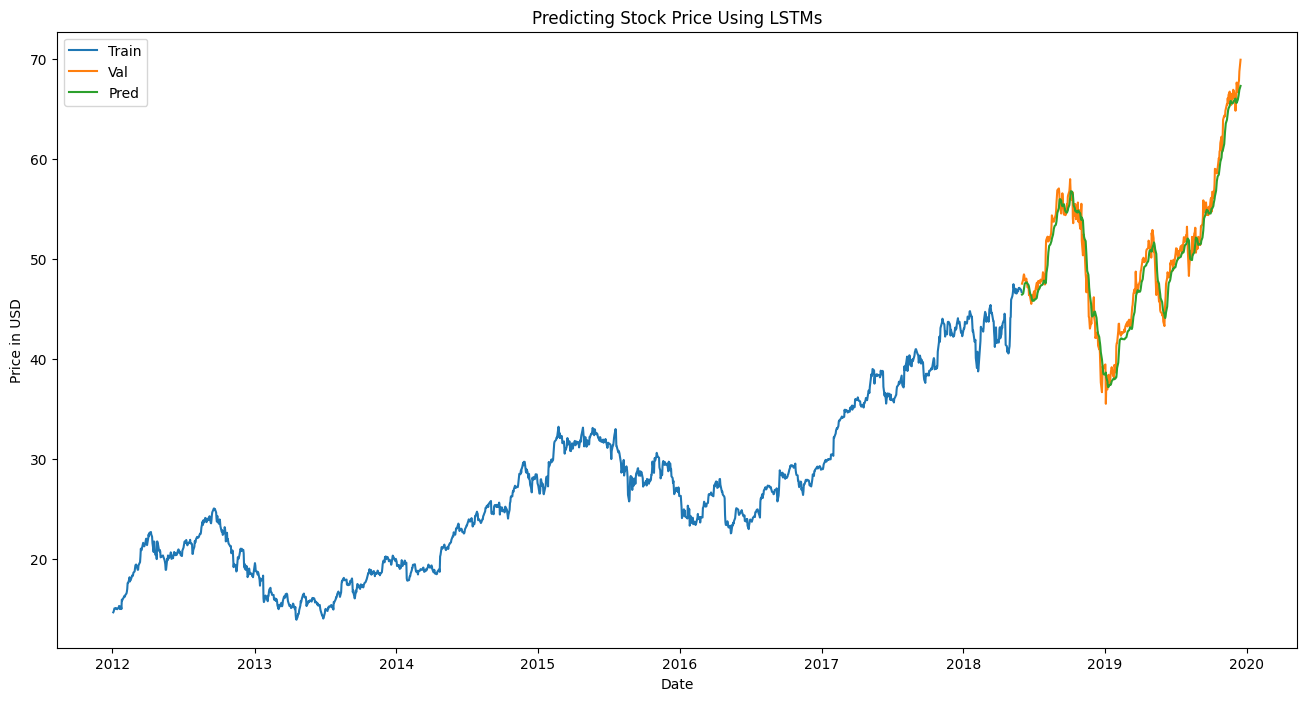

In [11]:
train = df[:-test_len]
valid = df[-test_len:]
valid.loc[:,'Pred'] = pred
fig = plt.figure(figsize=(16,8))
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Pred']])
plt.title('Predicting Stock Price Using LSTMs')
plt.xlabel('Date')
plt.ylabel('Price in USD')
plt.legend(['Train', 'Val', 'Pred'])
plt.show()
# fig.savefig('_static/StockPrediction_LSTM.png')